# Code for clustering video frames:

## Load the necessary libraries:

In [27]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.gmeans import gmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

In [2]:
import os
import random
import argparse
import torch
import torch.nn as nn
import types
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Extract deep features:

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_dir = 'test_target'

In [5]:
#Read the data to get the GMeans and XMeans clusters from before
#(Instead of running all the code below again)
tsne_results = pd.read_csv('tsne_results_20perpl.csv')

In [4]:
#Change the forward function to avoid getting output from the output layer:
def _forward_impl(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    return x

In [5]:
#Import the pretrained resnet50 model:
model = models.resnet50(pretrained=True)
model._forward_impl = types.MethodType(_forward_impl, model)    

In [6]:
#Data transformation:
data_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

In [7]:
#Load the data:
my_dataset = datasets.ImageFolder('test_target', data_transforms)
my_loader = DataLoader(my_dataset, batch_size=50, shuffle=False, num_workers=4) 
my_classes = my_dataset.classes

In [8]:
results = []
all_true = []
#Predict each instance in the dataloader:
for i, (inputs, y_true) in enumerate(my_loader):
        inputs = inputs.to(DEVICE)
        y_pred = model(inputs)
        #Convert to ndarray:
        y_pred = y_pred.detach().cpu().numpy()
        y_true = y_true.detach().cpu().numpy()
        results.append(y_pred)
        all_true.append(y_true)

In [9]:
#Merges results from all batches:
array_results = results[0]
y_true_gathered = all_true[0]
print(array_results)
for i in range(len(results)-1):
    array_results = np.concatenate((array_results, results[i + 1]), axis = 0)
    y_true_gathered = np.concatenate((y_true_gathered, all_true[i + 1]), axis = 0)

[[0.4645545  0.11810637 0.7767962  ... 0.22013551 0.3981779  0.37162435]
 [0.2880662  0.6208785  0.30450717 ... 0.37624204 0.64620715 0.31410977]
 [0.19965024 0.47486213 0.31061628 ... 0.2145788  0.64082426 0.37989247]
 ...
 [0.53967506 0.52309364 0.5390868  ... 0.31851315 0.37697044 0.24571048]
 [0.47677448 0.66435415 0.3239269  ... 0.33876148 0.45679933 0.43678454]
 [0.33334947 0.531751   0.51384217 ... 0.299751   0.36447495 0.4004204 ]]


## Do t-SNE for dim.red. on the extracted features:

In [10]:
#TSNE:
#Choose perplexity = 20 (tested 10, 15, 20, 30)
tsne = TSNE(n_components=2, perplexity = 20, random_state=0)
tsne_results = tsne.fit_transform(array_results)

In [11]:
tsne_results = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
tsne_results['class'] = y_true_gathered

### Plot the results:

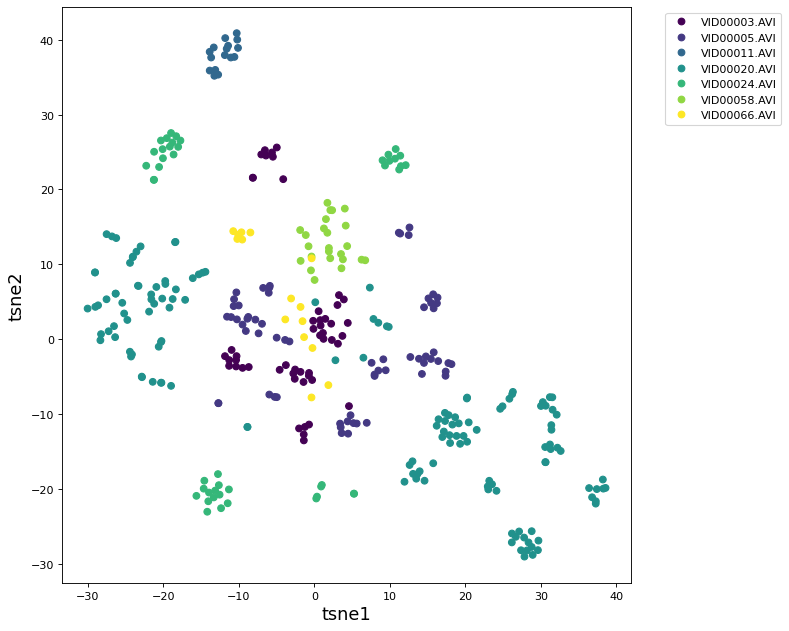

In [12]:
#Perplexity = 20
plt.figure(figsize=(10, 8), dpi=80)
scatter = plt.scatter(tsne_results['tsne1'], tsne_results['tsne2'], c  = tsne_results['class'])
#plt.legend()
plt.legend(handles=scatter.legend_elements()[0], labels=my_classes, loc = 'upper left', bbox_to_anchor=(1.05, 1.0))
plt.xlabel('tsne1', size = 16)
plt.ylabel('tsne2', size = 16)
plt.draw()
plt.tight_layout()
fig = plt.gcf()

## Test X-means to find optimal number of clusters:

Link to the tutorial: https://pyclustering.github.io/docs/0.9.0/html/dd/db4/classpyclustering_1_1cluster_1_1xmeans_1_1xmeans.html

In [13]:
#Convert the df to list of lists (for plotting with the cluster_visualizer)
lol = tsne_results.iloc[:,:2].values.tolist()

In [24]:
# Create instance of X-Means algorithm. 
#The algorithm will start analysis from 8 clusters, the maximum
# number of clusters that can be allocated is 200 (359 samples in total, so higher numbers doesn't make sense).
amount_initial_centers = 8
initial_centers = kmeans_plusplus_initializer(lol, amount_initial_centers).initialize()
test_xmeans_instance = xmeans(data = lol, initial_centers = initial_centers, kmax =200, tolerance = 0.025)
test_xmeans_instance.process()

In [25]:
# Extract clustering results: clusters and their centers
testclusters = test_xmeans_instance.get_clusters()
testcenters = test_xmeans_instance.get_centers()

In [26]:
#Number of clusters change when running the code several times:
len(testclusters)

9

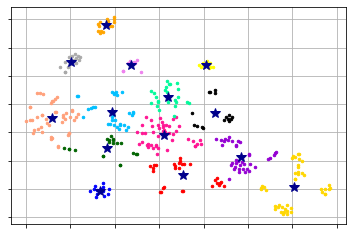

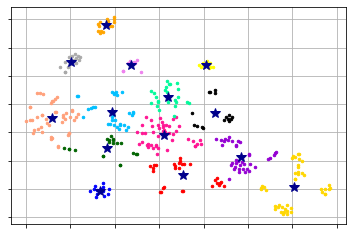

In [22]:
#Plot the clusters:
#Link to documentation: 
#https://pyclustering.github.io/docs/0.9.0/html/d5/def/classpyclustering_1_1cluster_1_1cluster__visualizer.html#a6f9a8fdd26d710f0b91625f8bb2475ad
visualizer = cluster_visualizer()
visualizer.append_clusters(testclusters, lol)
visualizer.append_cluster(testcenters, None, marker='*', markersize=10)
visualizer.show()

In [28]:
#Mark every image to which cluster it belongs to:
tsne_results['cluster'] = 99
for i in range(len(testclusters)):
    tsne_results.loc[testclusters[i], 'cluster'] = i + 1

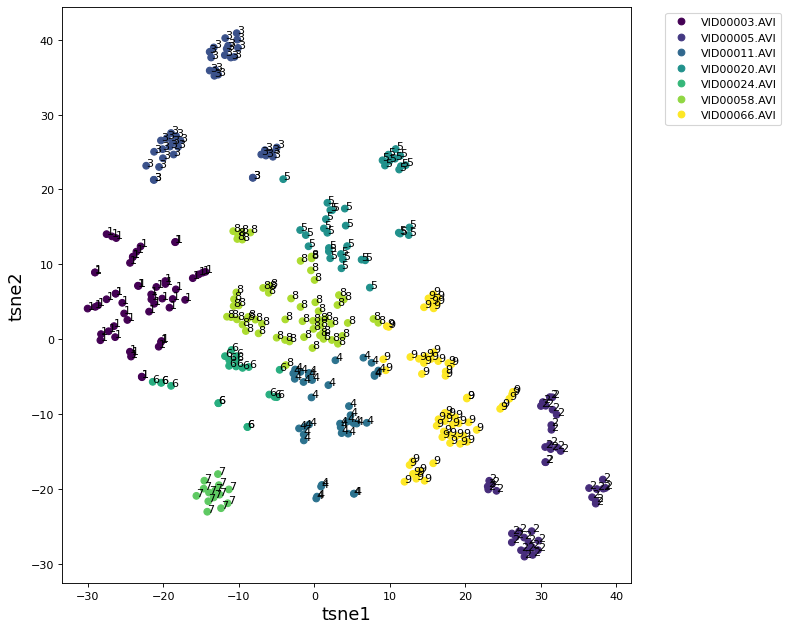

In [30]:
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(tsne_results.iloc[:, 0], tsne_results.iloc[:, 1], c=tsne_results['cluster'])
plt.legend(handles=scatter.legend_elements()[0], labels=my_classes, loc = 'upper left', bbox_to_anchor=(1.05, 1.0))
plt.xlabel('tsne1', size = 16)
plt.ylabel('tsne2', size = 16)

for i in range(np.shape(tsne_results)[0]):
    plt.text(tsne_results.iloc[i,0], tsne_results.iloc[i,1], tsne_results.iloc[i,-1])

plt.draw()
plt.tight_layout()
fig = plt.gcf()

# G-Means

### Used because more stable number of clusters

In [31]:
# Create instance of G-Means algorithm. By default algorithm start search from single cluster.
gmeans_instance = gmeans(lol, repeat = 10).process()

In [32]:
# Extract clustering results: clusters and their centers
gmeans_clusters = gmeans_instance.get_clusters()
gmeans_centers = gmeans_instance.get_centers()

In [33]:
len(gmeans_centers)

29

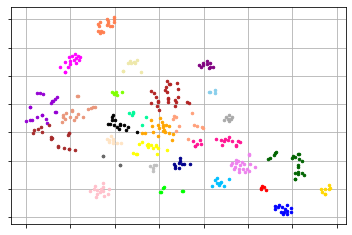

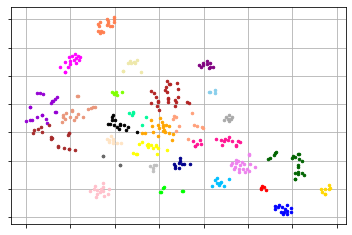

In [34]:
# Visualize clustering results
visualizer = cluster_visualizer()
visualizer.append_clusters(gmeans_clusters, lol)
visualizer.show()

In [35]:
#Mark every image to which cluster it belongs to:
tsne_results['gmeans_cluster'] = 99
for i in range(len(gmeans_clusters)):
    tsne_results.loc[gmeans_clusters[i], 'gmeans_cluster'] = i + 1

### Plot the results:

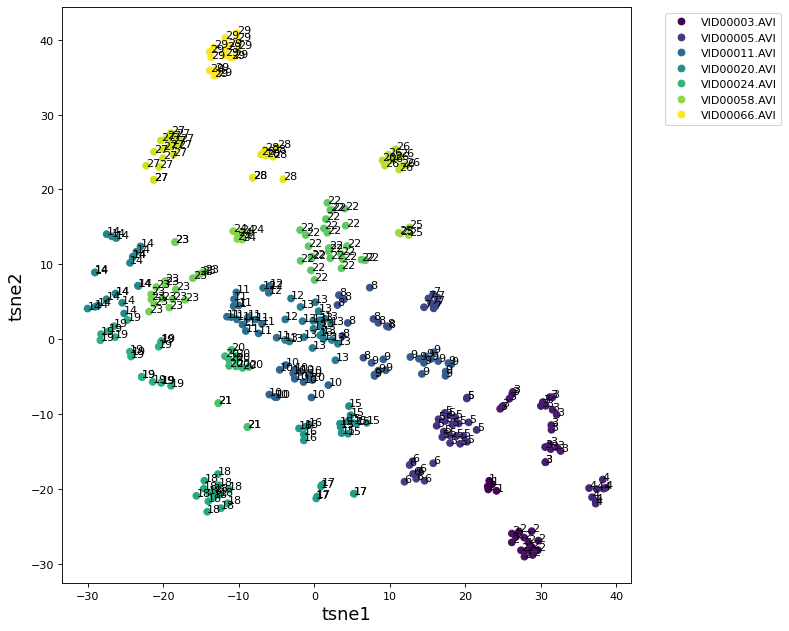

In [37]:
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(tsne_results.iloc[:, 0], tsne_results.iloc[:, 1], c=tsne_results['gmeans_cluster'])
plt.legend(handles=scatter.legend_elements()[0], labels=my_classes, loc = 'upper left', bbox_to_anchor=(1.05, 1.0))
plt.xlabel('tsne1', size = 16)
plt.ylabel('tsne2', size = 16)

for i in range(np.shape(tsne_results)[0]):
    plt.text(tsne_results.iloc[i,0], tsne_results.iloc[i,1], tsne_results.iloc[i,-1])

plt.draw()
plt.tight_layout()
fig = plt.gcf()

In [38]:
#Can write results for later use:
#tsne_results.to_csv('tsne_results_20perpl.csv', index=False)